# Prueba de clasificación embbeddings con espectros.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from nltk.tokenize import word_tokenize
import nltk
import we_to_signal as wes

[nltk_data] Downloading package punkt to /home/ulises/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/ulises/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#Con los poemas separados, los metemos en un diccionario de dataframes
import os

data_path = "data/"
emotion_list = ["anger", "anticipation", "disgust", "fear", "joy", "sadness", "surprise", "trust"]

json_files = sorted([pos_json for pos_json in os.listdir(data_path) if pos_json.endswith('.json')])
json_files.remove('Poems.json')
json_files.remove('missing.json')

em_poems = {}
for e in emotion_list:
    f = open(data_path+e+".json")
    df_ = pd.DataFrame(json.load(f))
    em_poems[e] = df_
em_poems["anger"]

,poem,id
0,i do know this it's nothing i can hold\nlast ...,10
1,the fear o' hell's a hangman's whip\nto haud t...,18
2,but since i laid a hand thereon\nand found a h...,88
3,falsely i pointed to sum in text\nseriously he...,99
4,i'll wear my jealous reflection\njuice of lemo...,125
...,...,...
2461,new snow on a leaf\nlike granulated sugar\nmak...,93124
2462,new earth and old earth\na trio of guardians\n...,93138
2463,destructions despair\nconstructions hope toge...,93217
2464,hot dry summers will\nbake paint right off the...,93226


In [3]:
#Carga de embeddings
from gensim.models import Word2Vec
from gensim.models import FastText

emotion_list = ["anger", "anticipation", "disgust", "fear", "joy", "sadness", "surprise", "trust"]

poems_w2v = {}
poems_fst = {}

for e in emotion_list:
    w2v_lines = Word2Vec.load("embeddings_poems/w2v_model_"+e)
    fst_lines = FastText.load("embeddings_poems/fst_model_"+e)
    poems_w2v[e] = w2v_lines
    poems_fst[e] = fst_lines

In [4]:
from nltk.corpus import stopwords

set_ = set()
for emotion in emotion_list:
    fst = set(poems_fst[emotion].wv.key_to_index.keys())
    w2v = set(poems_w2v[emotion].wv.key_to_index.keys())
    intersection = fst & w2v
    if not set_:
        set_ = set_.union(intersection)
    else:
        set_ = set_.intersection(intersection)

stop_words = set(stopwords.words('english'))
set_ = set_ - stop_words
len(set_)

562

In [5]:
from collections import Counter

def get_word_freq(dataframe:pd.DataFrame,col:str,emotion_list:list):
    """
    Calculates for Counter model of each emotion text corpus.

    Parameters
    ------------
    dataframe: pandas Dataframe with documents.
    col:str name of the column where the documents are.
    emotion_list: list with emotions

    Returns
    -----------
    dict:
        dictionary with keys(emotions_list) an each key with his self Counter model.
    """
    freq_dict = {}
    for emotion in emotion_list:
        tokens = dataframe[emotion][col].apply(lambda x: [token for token in word_tokenize(x)])
        l1 = tokens.values.tolist()
        l2 = [w for l in l1 for w in l ]
        freq_dict[emotion] = Counter(l2)
    return freq_dict

In [6]:
def text_clean(sent):
    import re
    from unidecode import unidecode
    import unicodedata as ud

    d = {ord('\N{combining acute accent}'):None}
    sent = ud.normalize('NFD',sent).translate(d)
    sent = re.sub(r"[^\w .,;?!\n]+", "", sent)
    sent = re.sub(r"[^\w .,;?!]", " ", sent)
    sent = re.sub(r"[^\w .,]", ".", sent)
    sent = re.sub(r"[^\w ]", "", sent)
    sent = re.sub(r"[0-9]", "", sent)
    sent = re.sub(r"[α-ωςϑϕϜϝϞϠϰϱ]", "", sent)
    sent = re.sub(r"[ΓΔΕΖΗΘΙΚΛΜΝΞΟΠΡΣΤΥΦΧΨΩ]", "", sent)
    sent = re.sub(r"[A-Z]{2}", "", sent)
    return sent

In [7]:
em_poem_c = dict()

for emotion in emotion_list:
    em_poem_c[emotion] = em_poems[emotion].copy()

for emotion in emotion_list:
    em_poem_c[emotion]["poems_clean"] = em_poem_c[emotion]["poem"].apply(text_clean)

freq_dict = get_word_freq(em_poem_c,"poems_clean",emotion_list)

In [8]:
from itertools import combinations
from scipy.stats import pearsonr

def get_words_info(model,set_,freq_dict):
    emotion_combinations = list(combinations(emotion_list,2))

    words_embbed_info = {}
    words_embbed_info["words"] = list(set_)

    for emotion in emotion_list:
        words_embbed_info["f_"+emotion] = []

    for comb in emotion_combinations:
        words_embbed_info["P_"+str(comb)] = []

    for word in set_:
        #Añadimos la frecuencia por cada emoción
        for emotion in emotion_list:
            words_embbed_info["f_"+emotion].append(freq_dict[emotion][word])

        #Calculamos la correlacion pearson para cada par de emociones.    
        for comb in emotion_combinations:
            emotion_a = comb[0]
            emotion_b = comb[1]

            words_embbed_info["P_"+str(comb)].append(pearsonr(model[emotion_a].wv.get_vector(word,norm=True),model[emotion_b].wv.get_vector(word,norm=True)))
        
    words_embbed = pd.DataFrame(words_embbed_info)
    return words_embbed

In [9]:
words_embbed_w2v_info = get_words_info(poems_w2v,set_,freq_dict)

In [10]:
words_embbed_fst_info = get_words_info(poems_fst,set_,freq_dict)

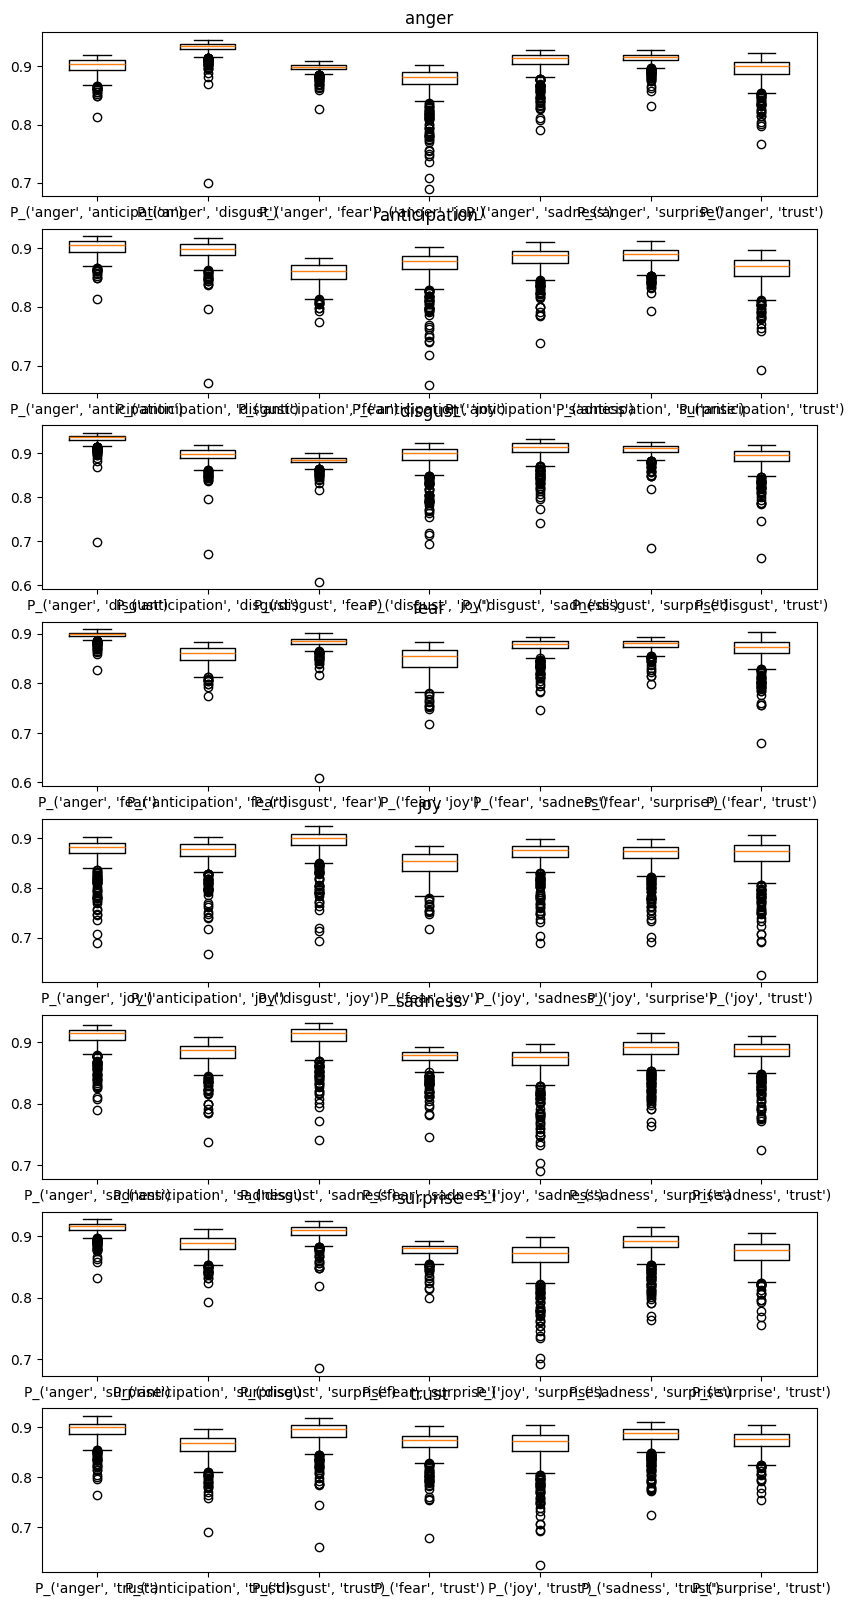

In [17]:
fig,ax = plt.subplots(8,figsize=(10,20))
columns = words_embbed_w2v_info.columns
i = 0
for emotion in emotion_list:
    data = []
    labels = []
    for column in columns:
        if emotion in column:
            if 'f_' in column:
                continue
            data.append([element[0] for element in words_embbed_w2v_info[column]])
            labels.append(column)
    ax[i].boxplot(data)
    ax[i].set_xticklabels(labels)
    ax[i].set_title(emotion)
    i+=1

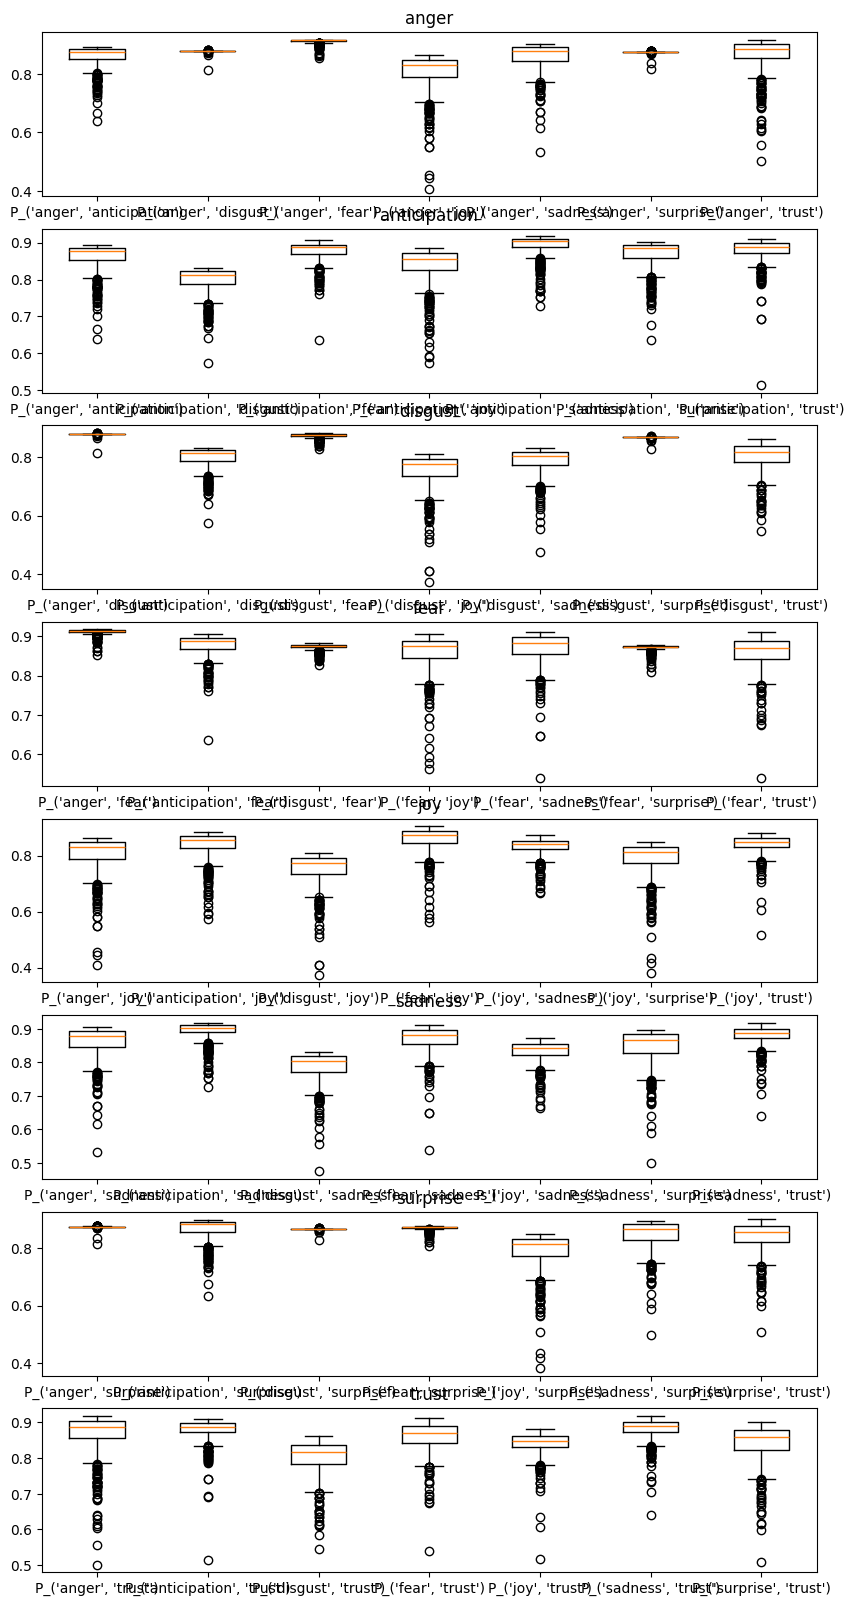

In [19]:
fig,ax = plt.subplots(8,figsize=(10,20))
columns = words_embbed_w2v_info.columns
i = 0
for emotion in emotion_list:
    data = []
    labels = []
    for column in columns:
        if emotion in column:
            if 'f_' in column:
                continue
            data.append([element[0] for element in words_embbed_fst_info[column]])
            labels.append(column)
    ax[i].boxplot(data)
    ax[i].set_xticklabels(labels)
    ax[i].set_title(emotion)
    i+=1

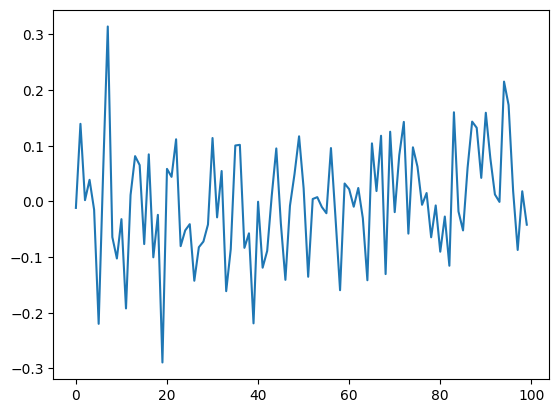

In [23]:
from memspectrum import MESA

word = poems_w2v["disgust"].wv.get_vector("died",norm=True)
plt.plot(word)

0.0


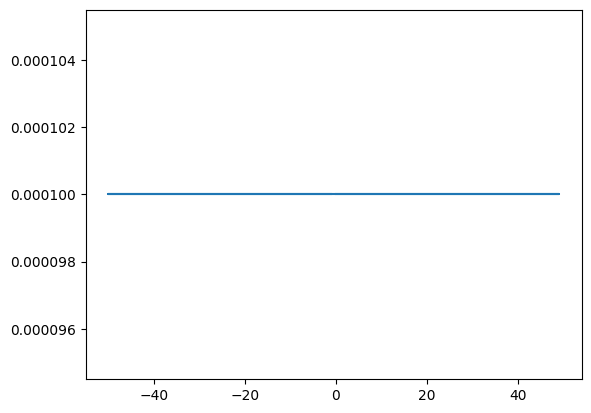

In [32]:
M = MESA()
M.solve(word)
frecuencies,spectrum = M.spectrum(1/len(word))

plt.plot(frecuencies,spectrum)
print(frecuencies[np.argmax(spectrum)])

In [66]:
freq_fst = {}
freq_w2v = {}

for emotion in emotion_list:
    freq_fst[emotion] = []
    freq_w2v[emotion] = []

    words_fst = poems_fst[emotion].wv.key_to_index.keys()
    words_w2v = poems_w2v[emotion].wv.key_to_index.keys()

    M = MESA()
    for word in words_fst:
        vector = poems_fst[emotion].wv.get_vector(word,norm=True)
        M.solve(vector)
        frecuencies,spectrum = M.spectrum(1/len(vector))
        freq = frecuencies[np.argmax(spectrum)]

        freq_fst[emotion].append(freq)

    for word in words_w2v:
        vector = poems_w2v[emotion].wv.get_vector(word,norm=True)
        M.solve(vector)
        frecuencies,spectrum = M.spectrum(1/len(vector))
        freq = frecuencies[np.argmax(spectrum)]

        freq_w2v[emotion].append(freq)

[-2.2080174927113703, -2.164023892398264, -1.02663195835002, -1.739540646145049, -1.507108403148007, -2.727731092436975, -1.6105769230769231, -3.4090430779348897]
[0.0, -0.04363636363636364, 0.01129032258064516, 0.008840864440078585, -0.24825244657479528, 0.04990795663734915, 0.0, -1.4306489444878812]


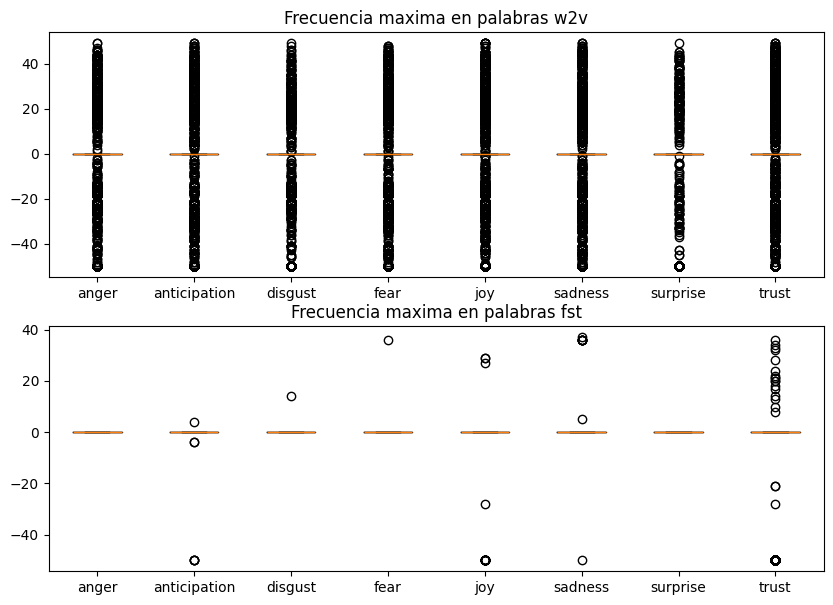

In [67]:
fig,ax = plt.subplots(2,figsize=(10,7))


labels = [label for label in freq_w2v.keys()]
data = [freq_w2v[label] for label in labels]
ax[0].boxplot(data)
ax[0].set_xticklabels(labels)
ax[0].set_title("Frecuencia maxima en palabras w2v")
medias_freq_spec_w2v = [np.mean(data[i]) for i in range(len(data))]
print(medias_freq_spec_w2v)

labels = [label for label in freq_w2v.keys()]
data = [freq_fst[label] for label in labels]
ax[1].boxplot(data)
ax[1].set_xticklabels(labels)
ax[1].set_title("Frecuencia maxima en palabras fst")

medias_freq_spec_fst = [np.mean(data[i]) for i in range(len(data))]
print(medias_freq_spec_fst)

In [74]:
freq = medias_freq_spec_w2v.copy()

freq = (freq-np.min(freq))/(np.max(freq)-np.min(freq))
print(medias_freq_spec_w2v)
print(freq)

[-2.2080174927113703, -2.164023892398264, -1.02663195835002, -1.739540646145049, -1.507108403148007, -2.727731092436975, -1.6105769230769231, -3.4090430779348897]
[0.50412189 0.52258788 1.         0.70076169 0.79832345 0.28597583
 0.75489328 0.        ]


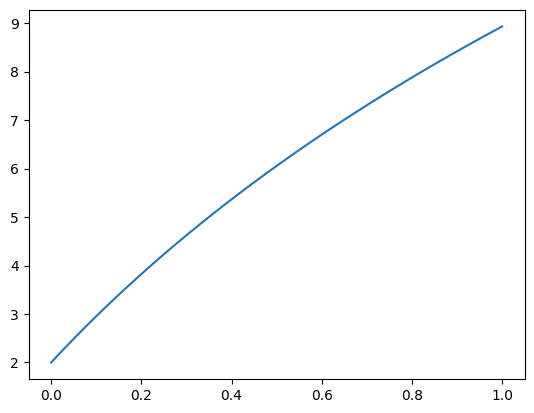

In [103]:
x = np.linspace(0,1,100)
y = 10*np.log(1+x) + 2
plt.plot(x,y)

In [107]:
frecuencies =  10*np.log(1 + freq) + 2

emotion_frecuencies = {}
for emotion,i in zip(emotion_list,range(8)):
    emotion_frecuencies[emotion] = frecuencies[i]

emotion_frecuencies

{'anger': 6.082092630183861,
 'anticipation': 6.204114423439578,
 'disgust': 8.931471805599454,
 'fear': 7.310762010303861,
 'joy': 7.868548166438853,
 'sadness': 4.515178270663142,
 'surprise': 7.624080484601741,
 'trust': 2.0}

In [113]:
with open("mod_embeddings_w2v.csv", 'w') as archivo:
    header = ""
    for i in range(100):
        header += "N"+str(i)+","
    header += "emotion\n"
    archivo.write(header)
    
    for emotion in emotion_list:
        words = poems_w2v[emotion].wv.key_to_index.keys()
        for word in words:
            vector = poems_w2v[emotion].wv.get_vector(word,norm=True)
            # Samples per second
            sps = 100

            # Duration
            duration_s = 1.0

            # ac: amplitude of the carrier.
            # carrier_hz: Frequency of the carrier
            # k_p: deviation constant
            carrier_amplitude = 1.0
            carrier_hz = emotion_frecuencies[emotion]
            k = 25.0

            # First, define our range of sample numbers
            each_sample_number = np.arange(duration_s * sps)

            # Create the term that create the carrier
            carrier = 2 * np.pi * each_sample_number * carrier_hz / sps

            # Now create the modulated waveform, and attenuate it
            vector = np.cos(carrier + k*vector)
            vector = vector/np.linalg.norm(vector)

            info = ""
            for i in range(len(vector)):
                info += str(vector[i]) + ","
            info += str(emotion)
            archivo.write(info+"\n")

In [114]:
with open("mod_embeddings_fst.csv", 'w') as archivo:
    header = ""
    for i in range(100):
        header += "N"+str(i)+","
    header += "emotion\n"
    archivo.write(header)
    for emotion in emotion_list:
        words = poems_fst[emotion].wv.key_to_index.keys()
        for word in words:
            vector = poems_fst[emotion].wv.get_vector(word,norm=True)
            # Samples per second
            sps = 100

            # Duration
            duration_s = 1.0

            # ac: amplitude of the carrier.
            # carrier_hz: Frequency of the carrier
            # k_p: deviation constant
            carrier_amplitude = 1.0
            carrier_hz = emotion_frecuencies[emotion]
            k = 25.0

            # First, define our range of sample numbers
            each_sample_number = np.arange(duration_s * sps)

            # Create the term that create the carrier
            carrier = 2 * np.pi * each_sample_number * carrier_hz / sps

            # Now create the modulated waveform, and attenuate it
            vector = np.cos(carrier + k*vector)
            vector = vector/np.linalg.norm(vector)

            info = ""
            for i in range(len(vector)):
                info += str(vector[i]) + ","
            info += str(emotion)
            archivo.write(info+"\n")

In [115]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

df_w2v = pd.read_csv("mod_embeddings_w2v.csv")
df_fst = pd.read_csv("mod_embeddings_fst.csv")

display(df_w2v)
display(df_fst)

,N0,N1,N2,N3,N4,N5,N6,N7,N8,N9,...,N91,N92,N93,N94,N95,N96,N97,N98,N99,emotion
0,-0.039106,-0.129636,0.134212,-0.115996,0.094007,-0.124803,-0.090776,-0.125005,0.097257,0.119502,...,-0.046043,-0.119128,-0.025353,-0.085906,0.040137,0.131097,-0.130923,0.132307,0.128282,anger
1,-0.043838,-0.129377,0.134205,-0.109900,0.087036,-0.124986,-0.091542,-0.124950,0.095179,0.120906,...,-0.047234,-0.120861,-0.030304,-0.089367,0.040816,0.130453,-0.131363,0.133114,0.127881,anger
2,-0.042660,-0.128889,0.133422,-0.110226,0.087581,-0.127471,-0.094391,-0.126264,0.097501,0.118360,...,-0.042837,-0.120398,-0.028930,-0.086344,0.038282,0.129282,-0.130605,0.131498,0.125510,anger
3,-0.041107,-0.130399,0.133479,-0.109191,0.086635,-0.123840,-0.095953,-0.125642,0.094517,0.121156,...,-0.046993,-0.120302,-0.026190,-0.086163,0.040181,0.130656,-0.130922,0.132830,0.126120,anger
4,-0.040003,-0.129132,0.134323,-0.103410,0.085192,-0.125791,-0.093571,-0.126709,0.092321,0.120296,...,-0.049161,-0.120338,-0.028987,-0.091829,0.047535,0.132361,-0.130147,0.133240,0.128794,anger
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153084,-0.063032,-0.135601,0.088262,-0.110689,0.140562,-0.006567,0.112575,-0.121935,0.048309,0.108004,...,-0.071186,-0.024307,-0.136086,-0.113070,-0.040205,-0.041507,-0.090455,-0.018701,-0.130559,trust
153085,-0.094895,0.095342,-0.080627,-0.026979,-0.104199,0.103075,0.018217,-0.019687,0.133132,0.157132,...,0.094201,0.101050,-0.087003,0.038978,-0.144778,-0.096347,0.147197,-0.158143,-0.054015,trust
153086,0.012665,-0.032021,0.138534,0.130305,0.130073,-0.025985,0.085447,-0.118039,0.111013,-0.140805,...,-0.117856,-0.142649,0.065674,-0.026196,0.136643,-0.102733,-0.113630,0.034575,0.141000,trust
153087,0.076149,-0.116132,-0.079565,0.093332,0.133188,-0.113274,-0.133562,-0.028872,0.130492,-0.044557,...,0.033406,-0.063495,0.115666,-0.092164,-0.110429,0.125946,-0.027073,-0.054504,0.123191,trust


,N0,N1,N2,N3,N4,N5,N6,N7,N8,N9,...,N91,N92,N93,N94,N95,N96,N97,N98,N99,emotion
0,0.014049,0.032629,0.062353,-0.132297,-0.120071,0.137850,0.061581,0.064418,-0.090465,0.101597,...,-0.128813,-0.112092,0.068646,-0.143802,0.137681,-0.031692,-0.040452,0.141912,-0.115111,anger
1,0.013067,0.030379,0.067266,-0.132596,-0.121308,0.136348,0.065483,0.062070,-0.086704,0.107226,...,-0.130236,-0.112943,0.077951,-0.143553,0.136330,-0.036563,-0.040029,0.141850,-0.114977,anger
2,0.005805,0.029348,0.060982,-0.131541,-0.125412,0.135512,0.067327,0.057996,-0.085531,0.104498,...,-0.133144,-0.114886,0.075406,-0.143760,0.136929,-0.035767,-0.039933,0.142560,-0.111036,anger
3,0.010535,0.031475,0.063228,-0.131445,-0.120766,0.139437,0.062170,0.057319,-0.084620,0.105368,...,-0.132028,-0.107569,0.079274,-0.144046,0.137972,-0.039730,-0.039064,0.142391,-0.113462,anger
4,0.007698,0.031869,0.063407,-0.129722,-0.121208,0.138401,0.065000,0.057527,-0.087101,0.105978,...,-0.130550,-0.107538,0.082051,-0.143499,0.138137,-0.039433,-0.046295,0.141955,-0.116360,anger
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29284,-0.068274,-0.090208,0.139029,0.012055,0.080956,0.006151,0.144007,-0.138167,0.103248,0.141053,...,0.045745,-0.119265,0.127410,-0.141187,0.020532,-0.039536,0.013884,0.134342,-0.025773,trust
29285,-0.034368,0.036890,-0.140576,-0.012241,0.104284,0.114634,0.097623,0.001682,-0.082986,-0.139322,...,-0.049702,-0.104496,0.093342,-0.132319,0.066483,0.017407,-0.095531,0.114648,-0.009320,trust
29286,0.141674,0.053277,-0.087639,0.068761,0.054283,-0.001721,0.102528,-0.081108,-0.142217,-0.138958,...,0.090184,-0.141083,0.104394,-0.018171,-0.035448,-0.085490,0.071729,0.131272,-0.095126,trust
29287,0.019411,0.059229,-0.118906,0.047082,0.114687,0.047613,0.113781,-0.086720,-0.067314,-0.138812,...,-0.034638,-0.132448,0.083575,-0.115183,0.039934,-0.016143,-0.056365,0.115911,-0.041701,trust
